In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import *
from filters import LKF_CA, LKF_CV
from measurement import MeasMixDoppler, MeasMixPositionOnly, MeasConverted, MeasCartesianPos
from simulation import *
from scenarios import get_scenario

In [2]:
def plot_xy(ax, meas, truth):
    ax.plot(meas[0, :], meas[1, :], '*', label='meas')
    ax.plot(truth[IX, :], truth[IY, :], 'k--', label='truth')
    ax.legend()
    ax.grid()
    ax.set_xlabel('Pos. X (m)')
    ax.set_ylabel('Pos. Y (m)')

def plot_eval(fig, gs, options: list, filters: list, frame_vec, data_kf, data_meas=None, data_truth=None):
    for p in options:
        ax = fig.add_subplot(gs[*p['grid_pos']])
        # filters
        for j, filt in enumerate(filters):
            ax.plot(frame_vec, data_kf[j, p['index'], :], '-', label=filt['label'], linewidth=2)
        # measurements
        if data_meas is not None and p.get('meas_index', None) is not None:
            ax.plot(frame_vec, data_meas[p['meas_index'], :], '.', label='measurement', linewidth=2)
        # truth
        if data_truth is not None:
            ax.plot(frame_vec, data_truth[p['index'], :], 'k--', label='truth', linewidth=2)
        ax.set_ylabel(p['ylabel'])
        ax.legend()
        ax.grid()

In [12]:
SEED = 10
np.random.seed(SEED)
T = 0.05 # time between cycles
dim_state = 6 # dimension of state
dim_meas = 3 # dimension of measurements
n_iter = 50
q_motion = [0.01**2/T, 0.01**2/T]
std_r, std_phi, std_doppler = 2.0, np.radians(1.0), 0.5
std_x, std_y = 1.0, 1.0
filters = [
    # {
    #     'kf': LKF_CA, 'meas_fn': MeasMixPositionOnly(std_r, std_phi), 'label': 'pos-only', 
    #     'kf_params': {'qvar_ax': 10**2, 'qvar_ay': 10**2}
    # },
    # {
    #     'kf': LKF_CA, 'meas_fn': MeasConverted(std_r, std_phi), 'label': 'converted', 
    #     'kf_params': {'qvar_ax': 10**2, 'qvar_ay': 10**2}
    # },
    {
        'kf': LKF_CA, 'meas_fn': MeasCartesianPos(std_x, std_y), 'label': 'linear pos q=0.05', 
        'kf_params': {'qvar_ax': 0.01**2/T, 'qvar_ay': 0.01**2/T}
    },
    {
        'kf': LKF_CA, 'meas_fn': MeasCartesianPos(std_x, std_y), 'label': 'linear pos q=0.1', 
        'kf_params': {'qvar_ax': 0.05**2/T, 'qvar_ay': 0.05**2/T}
    },
    {
        'kf': LKF_CA, 'meas_fn': MeasCartesianPos(std_x, std_y), 'label': 'linear pos q=0.2', 
        'kf_params': {'qvar_ax': 1**2/T, 'qvar_ay': 1**2/T}
    },
    # {
    #     'kf': LKF_CV, 'meas_fn': MeasCartesianPos(std_x, std_y), 'label': 'LKF_CV', 
    #     'kf_params': {'qvar_vx': (1*T)**2, 'qvar_vy': (1*T)**2}
    # },
    # {
    #     'kf': LKF_CA, 'meas_fn': MeasMixDoppler(std_r, std_phi, std_doppler), 'label': 'doppler', 
    #     'kf_params': {'qvar_ax': 5**2, 'qvar_ay': 5**2}
    # },
]
n_filters = len(filters)

# get scenario
sc_id = '2'
sc = get_scenario(sc_id, T)
n_frames = int(sc['n_frames'])
frame_vec = np.arange(n_frames)

# simulating truth motion
F_sim = LKF_CA.get_state_transition(T)
sim_state = simulate_motion(F_sim, dim_state, T, n_frames, sc['x_init'], sc.get('jerkx_frames'), sc.get('jerky_frames'), q_motion)

# run
kf_errors = np.zeros((n_filters, n_iter, dim_state, n_frames))
kf_norm_errors = np.zeros((n_filters, n_iter, dim_state, n_frames))
kf_mean_state = np.zeros((n_filters, dim_state, n_frames))
kf_mean_cov = np.zeros((n_filters, dim_state, n_frames))
kf_nees = np.zeros((n_filters, n_iter, n_frames))
kf_nis = np.zeros((n_filters, n_iter, n_frames))
meas_pos_errors_sq = np.zeros((n_iter, n_frames))
meas_mean_pos = np.zeros((2, n_frames)) 
for k in range(n_iter): 
    # meas = simulate_measurements_polar(sim_state, std_r, std_phi, std_doppler)
    meas = simulate_measurements_cartesian(sim_state, std_x, std_y, std_doppler)
    
    for i, filt in enumerate(filters):
        kf = filt['kf'](cycle_time = T, **filt.get('kf_params', None))
        meas_fn = filt['meas_fn']

        # applying KF
        kf_state = np.zeros_like(sim_state)
        kf_cov= np.zeros_like(sim_state)
        for frame in range(n_frames):
            cur_meas = meas[:, frame]
            if frame==0:
                # initializing KF
                x0, y0 = meas[[IMX, IMY], frame]
                state_init = np.array([x0, y0, 0, 0, 0, 0])
                kf.initialize_filter(state_init)
            else:
                kf.predict()
                # extracting measurement and measurement covariance
                if isinstance(meas_fn, (MeasCartesianPos, MeasConverted)):
                    z = cur_meas[[IMX, IMY]]
                else:
                    z = cur_meas[[IR, IT, ID]]
                est_meas, H_jac = meas_fn.meas_fn(kf.x)
                R = meas_fn.compute_R_matrix(meas_r = cur_meas[IR], meas_phi = cur_meas[IT])
                kf.update(z, est_meas, H_jac, R, compute_lk=False, compute_nis=True)

            # computing nees and normalized errors
            x_err = kf.x - sim_state[:len(kf.x), frame]
            kf_nis[i, k, frame] = kf.nis
            kf_nees[i, k, frame] = x_err.T @ np.linalg.inv(kf.P) @ x_err
            if isinstance(kf, LKF_CA):
                kf_state[:, frame] = kf.x
                kf_cov[:, frame] = np.diag(kf.P)
                kf_norm_errors[i, k, :, frame] = x_err/np.sqrt(np.diag(kf.P))
            else:
                kf_state[:, frame] = np.concatenate((kf.x, np.array([0, 0])))
                kf_cov[:, frame] = np.concatenate((np.diag(kf.P), np.array([100, 100])))
        
        # evaluation
        if i==0:
            meas_mean_pos += 1/n_iter * meas[[IMX, IMY], :]
            meas_pos_errors_sq[k, :] = (meas[IMX, :] - sim_state[IX, :])**2 + (meas[IMY, :] - sim_state[IY, :])**2
        kf_mean_state[i, :, :] += 1/n_iter * kf_state
        kf_mean_cov[i, :, :] += 1/n_iter * kf_cov
        kf_errors[i, k, :, :] = kf_state - sim_state[:, ]

mean_kf_nees = np.mean(kf_nees, axis=1)
mean_kf_nis = np.mean(kf_nis, axis=1)
mean_kf_norm_errors = np.mean(kf_norm_errors, axis=1)
meas_rms_error = np.sqrt(np.mean(meas_pos_errors_sq, axis=0))
# computing RMS error in position, velocity and acceleration
rms_error = np.zeros((n_filters, 3, n_frames)) # Pos, Vel, Acc
err_sq = kf_errors**2
rms_error[:, 0, :] = np.sqrt(np.mean(err_sq[:, :, IX, :] + err_sq[:, :, IY, :], axis=1))
rms_error[:, 1, :] = np.sqrt(np.mean(err_sq[:, :, IVX, :] + err_sq[:, :, IVY, :], axis=1))
rms_error[:, 2, :] = np.sqrt(np.mean(err_sq[:, :, IAX, :] + err_sq[:, :, IAY, :], axis=1))

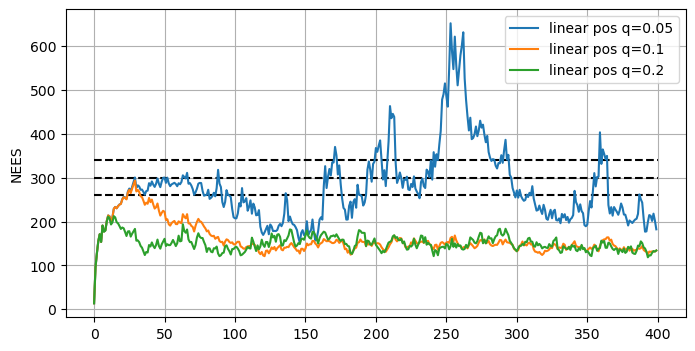

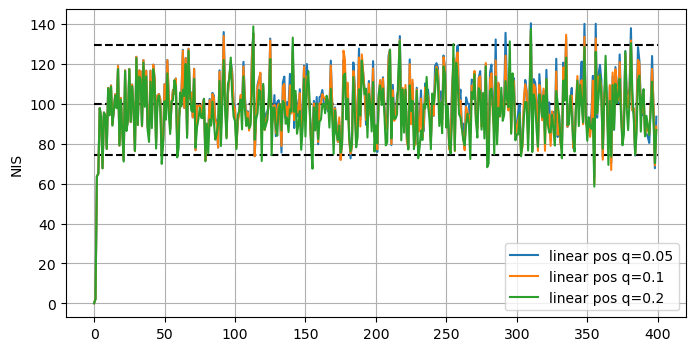

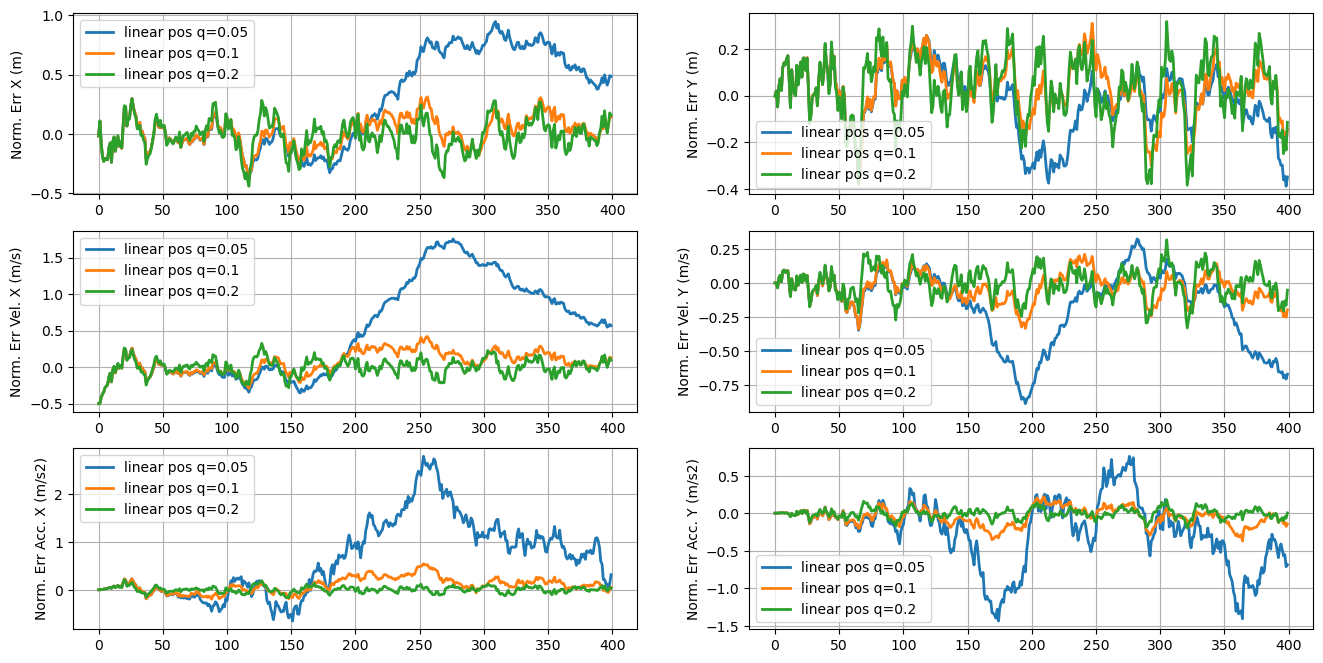

In [13]:
# consistency check

# NEES
expected_df = dim_state * n_iter
lims_05 = np.array([261, 341]) # for 95 % confidence with 50 iterations
fig, ax = plt.subplots(figsize=(8, 4))
ax.hlines(expected_df, 0, n_frames, colors='k', linestyles='dashed')
ax.hlines(lims_05[0], 0, n_frames, colors='k', linestyles='dashed')
ax.hlines(lims_05[1], 0, n_frames, colors='k', linestyles='dashed')
for j, filt in enumerate(filters):
    ax.plot(frame_vec, n_iter * mean_kf_nees[j, :].T, '-', label=filt['label'])
ax.legend()
# ax.set_ylim([0, 20])
ax.grid()
ax.set_ylabel('NEES')

# NIS
expected_df = 2 * n_iter
lims_05 = np.array([74.222, 129.561]) # for 95 % confidence with 50 iterations
fig, ax = plt.subplots(figsize=(8, 4))
ax.hlines(expected_df, 0, n_frames, colors='k', linestyles='dashed')
ax.hlines(lims_05[0], 0, n_frames, colors='k', linestyles='dashed')
ax.hlines(lims_05[1], 0, n_frames, colors='k', linestyles='dashed')
for j, filt in enumerate(filters):
    ax.plot(frame_vec, n_iter * mean_kf_nis[j, :].T, '-', label=filt['label'])
ax.legend()
# ax.set_ylim([0, 20])
ax.grid()
ax.set_ylabel('NIS')

# mean state
options_norm_errors = [
    {'grid_pos': (0, 0), 'index': IX, 'ylabel': 'Norm. Err X (m)'},
    {'grid_pos': (0, 1), 'index': IY, 'ylabel': 'Norm. Err Y (m)'},
    {'grid_pos': (1, 0), 'index': IVX, 'ylabel': 'Norm. Err Vel. X (m/s)'},
    {'grid_pos': (1, 1), 'index': IVY, 'ylabel': 'Norm. Err Vel. Y (m/s)'},
    {'grid_pos': (2, 0), 'index': IAX, 'ylabel': 'Norm. Err Acc. X (m/s2)'},
    {'grid_pos': (2, 1), 'index': IAY, 'ylabel': 'Norm. Err Acc. Y (m/s2)'},
]
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 2)
plot_eval(fig, gs, options_norm_errors, filters, frame_vec, mean_kf_norm_errors)

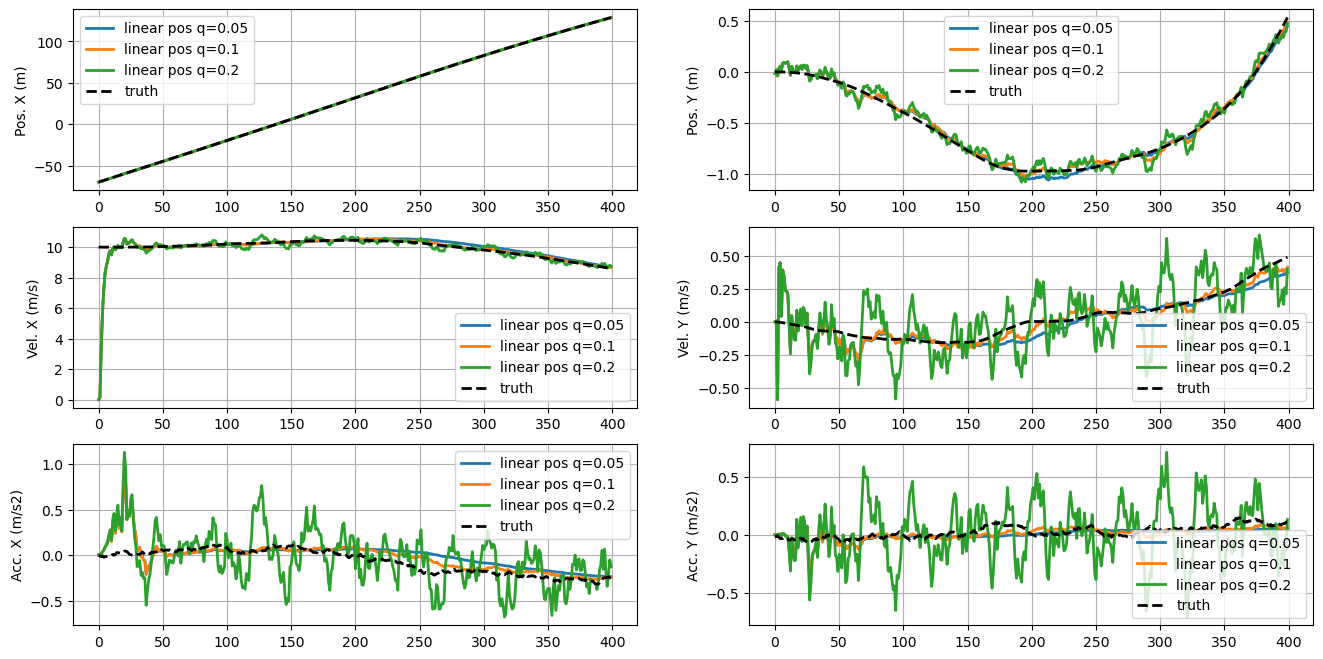

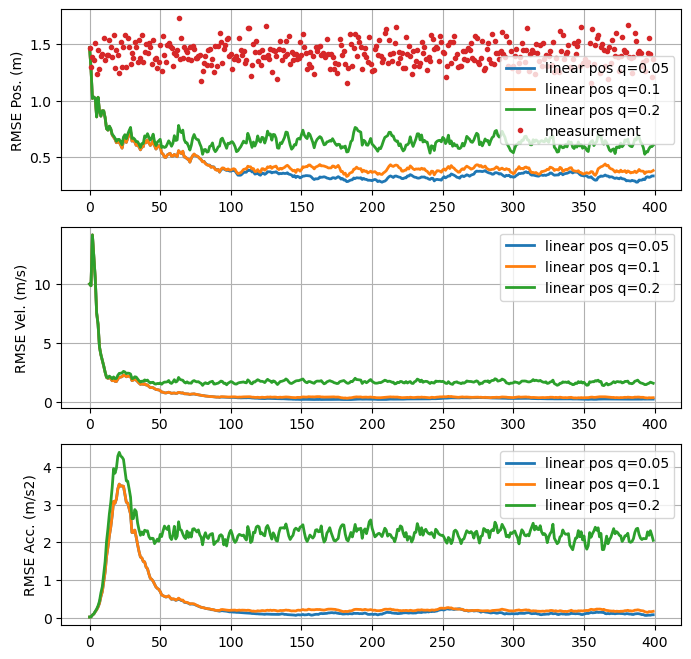

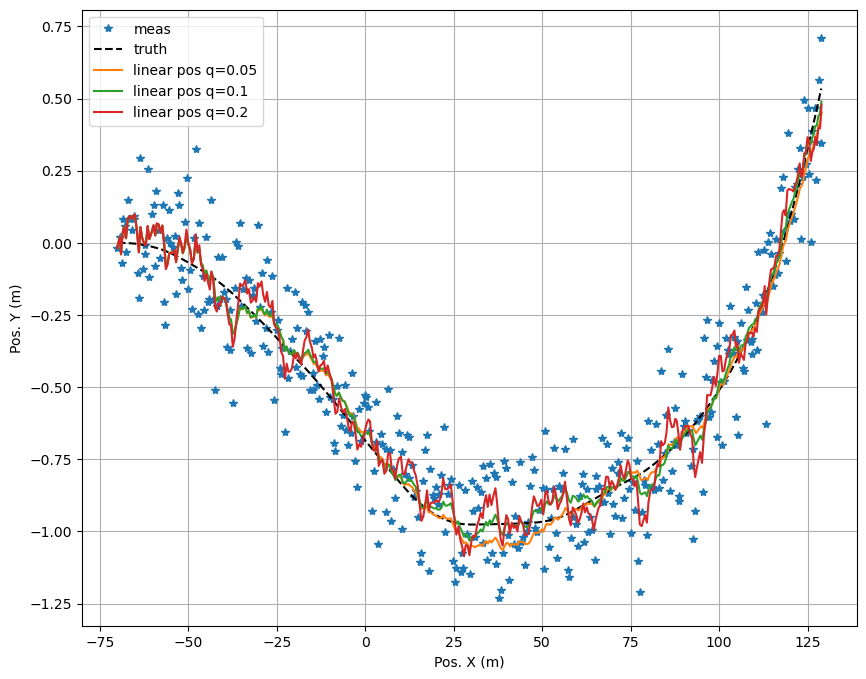

: 

In [14]:
# error viewer

# NEES
# fig, ax = plt.subplots(figsize=(10, 8))
# plot_xy(ax, meas_mean_pos, sim_state)
# for j, filt in enumerate(filters):
#     ax.plot(frame_vec, mean_kf_nees[j, :].T, '-', label=filt['label'])
# ax.legend()

# mean state
options_mean_state = [
    {'grid_pos': (0, 0), 'index': IX, 'ylabel': 'Pos. X (m)'},
    {'grid_pos': (0, 1), 'index': IY, 'ylabel': 'Pos. Y (m)'},
    {'grid_pos': (1, 0), 'index': IVX, 'ylabel': 'Vel. X (m/s)'},
    {'grid_pos': (1, 1), 'index': IVY, 'ylabel': 'Vel. Y (m/s)'},
    {'grid_pos': (2, 0), 'index': IAX, 'ylabel': 'Acc. X (m/s2)'},
    {'grid_pos': (2, 1), 'index': IAY, 'ylabel': 'Acc. Y (m/s2)'},
]
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 2)
plot_eval(fig, gs, options_mean_state, filters, frame_vec, kf_mean_state, meas_mean_pos, sim_state)
# plot_eval(fig, gs, options_mean_state, filters, frame_vec, np.sqrt(kf_mean_cov))

# RMS errors
options_rms_errors = [
    {'grid_pos': (0, 0), 'index': 0, 'ylabel': 'RMSE Pos. (m)', 'meas_index': 0},
    {'grid_pos': (1, 0), 'index': 1, 'ylabel': 'RMSE Vel. (m/s)'},
    {'grid_pos': (2, 0), 'index': 2, 'ylabel': 'RMSE Acc. (m/s2)'},
]
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(3, 1)
plot_eval(fig, gs, options_rms_errors, filters, frame_vec, rms_error, np.expand_dims(meas_rms_error, axis=0))

# XY plot
fig, ax = plt.subplots(figsize=(10, 8))
plot_xy(ax, meas_mean_pos, sim_state)
for j, filt in enumerate(filters):
    ax.plot(kf_mean_state[j, IX, :], kf_mean_state[j, IY, :], '-', label=filt['label'])
ax.legend()

In [6]:
T = 3

q = np.diag([1, 1])
gamma_DWPA = np.array([
    [0.5*T**2, 0],
    [0,        0.5*T**2],
    [T,        0],
    [0,        T],
    [1,        0],
    [0,        1],
])
gamma_CWPA = np.array([
    [T**3/6, 0],
    [0,        T**3/6],
    [T**2/2, 0],
    [0,        T**2/2],
    [T,        0],
    [0,        T],
])

Q = gamma_CWPA@q@gamma_CWPA.T

Q_expected_DWPA = np.array([
    [T**4/4, T**3/2, T**2/2],
    [T**3/2, T**2, T],
    [T**2/2, T, 1],
])
Q_expected_CWPA = np.array([
    [T**5/20, T**4/8, T**3/6],
    [T**4/8, T**3/3, T**2/2],
    [T**3/6, T**2/2, T],
])

print(Q)
print(Q_expected_CWPA)

[[20.25  0.   20.25  0.   13.5   0.  ]
 [ 0.   20.25  0.   20.25  0.   13.5 ]
 [20.25  0.   20.25  0.   13.5   0.  ]
 [ 0.   20.25  0.   20.25  0.   13.5 ]
 [13.5   0.   13.5   0.    9.    0.  ]
 [ 0.   13.5   0.   13.5   0.    9.  ]]
[[12.15  10.125  4.5  ]
 [10.125  9.     4.5  ]
 [ 4.5    4.5    3.   ]]
